In [1]:
!pip install pyicu   
!pip install pycld2  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.6/255.6 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyicu: filename=PyICU-2.10.2-cp37-cp37m-linux_x86_64.whl size=1904562 sha256=16935e768ed9fc67347487f3485420defa35e3650c8008f25c02031ac1e9178e
  Stored in directory: /root/.cache/pip/wheels/eb/9a/92/8aac41f3aecd15d913695d08f07687cf1d92067e3d38995968
Successfully built pyicu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 20.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9918573 sha256=49b52028147803801343de94469ef96c90e7c1858e29f55d964670ca07a03b97
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from nltk.corpus import stopwords
from tqdm import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
from polyglot.detect import Detector
from nltk.sentiment import SentimentIntensityAnalyzer
import tensorflow as tf

# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

0it [00:00, ?it/s]

In [3]:
path = "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/"
os.listdir(path)

['sample_submission.csv',
 'test_labels.csv',
 'validation-processed-seqlen128.csv',
 'test-processed-seqlen128.csv',
 'jigsaw-unintended-bias-train-processed-seqlen128.csv',
 'validation.csv',
 'jigsaw-toxic-comment-train.csv',
 'test.csv',
 'jigsaw-unintended-bias-train.csv',
 'jigsaw-toxic-comment-train-processed-seqlen128.csv']

In [4]:
train_df = pd.read_csv(path + "jigsaw-toxic-comment-train.csv")
train_df.shape
train_df.head()

(223549, 8)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
val_df = pd.read_csv(path + "validation.csv")
val_df.shape
val_df.head()

(8000, 4)

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [6]:
val_df['lang'].value_counts()

tr    3000
es    2500
it    2500
Name: lang, dtype: int64

In [7]:
test_df = pd.read_csv(path + "test.csv")
test_df.shape
test_df.head()

(63812, 3)

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [8]:
test_df['lang'].value_counts()

tr    14000
pt    11012
ru    10948
fr    10920
it     8494
es     8438
Name: lang, dtype: int64

# EDA

In [9]:
train_df['id'].nunique()
train_df['toxic'].value_counts()

223549

0    202165
1     21384
Name: toxic, dtype: int64

In [10]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

toxic            21384
severe_toxic      1962
obscene          12140
threat             689
insult           11304
identity_hate     2117
dtype: int64

<Figure size 576x288 with 0 Axes>

Text(0.5, 1.0, 'Number of comments per class')

Text(0, 0.5, '# of Occurrences')

Text(0.5, 0, 'Class')

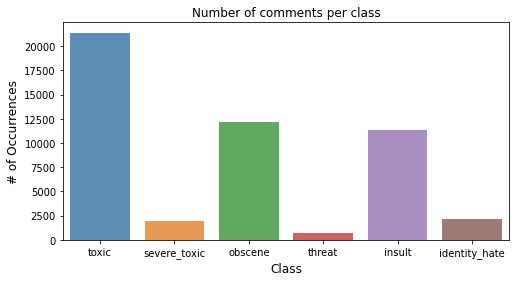

In [11]:
classes = train_df.iloc[:,2:]
class_dist = classes.sum()
class_dist
plt.figure(figsize=(8,4))
ax= sns.barplot(class_dist.index, class_dist.values, alpha=0.8)
plt.title("Number of comments per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)

0    201081
1      8202
3      6290
2      5010
4      2371
5       550
6        45
Name: tag_counts, dtype: int64

Text(0.5, 1.0, 'Number of comments per class')

Text(0, 0.5, '# of Occurrences')

Text(0.5, 0, 'Class')

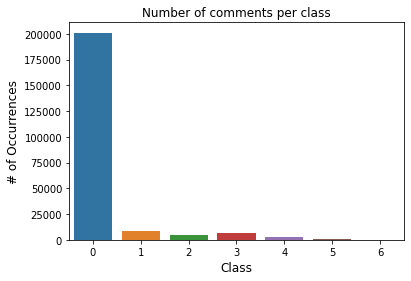

In [12]:
train_df['tag_counts'] = train_df['toxic'] + train_df['severe_toxic'] + train_df['obscene'] + train_df['threat'] + train_df['insult'] + train_df['identity_hate']
train_df['tag_counts'].value_counts()
ax= sns.countplot(train_df['tag_counts'])
plt.title("Number of comments per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)

In [13]:
cols = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
cross_tab_mat = []
for col in cols:
    cross_tab = pd.crosstab(train_df['toxic'], train_df[col])
    cross_tab_mat.append(cross_tab)

pd.concat(cross_tab_mat,axis=1,keys=cols)

severe_toxic       obscene         threat       insult         \
severe_toxic            0     1       0      1       0    1       0      1   
toxic                                                                        
0                  202165     0  201577    588  202130   35  201547    618   
1                   19422  1962    9832  11552   20730  654   10698  10686   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   202043   122  
1                    19389  1995

In [14]:
stopword = set(STOPWORDS)

<Figure size 1440x720 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Most frequent words in Non-Toxic Comments')

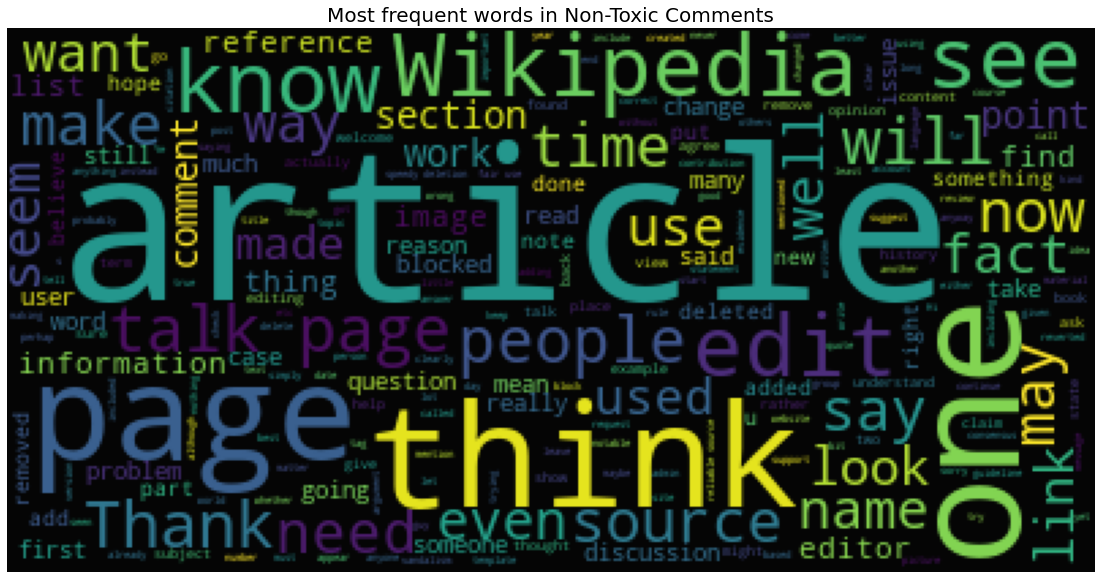

In [15]:
non_toxic_df = train_df[train_df['toxic'] == 0]
non_toxic_comments = non_toxic_df['comment_text'].values
word_cloud = WordCloud(background_color="black", max_words=3000, stopwords=stopword)
word_cloud.generate(" ".join(non_toxic_comments))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Most frequent words in Non-Toxic Comments", fontsize=20)
plt.imshow(word_cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

<Figure size 1440x720 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Most frequent words in Toxic Comments')

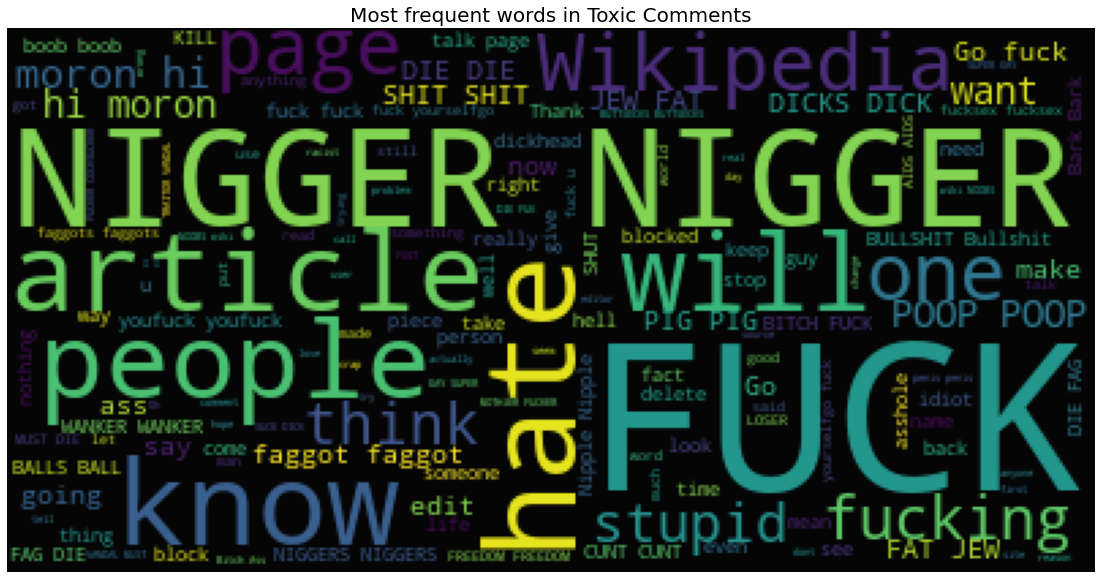

In [16]:
toxic_df = train_df[train_df['toxic'] == 1]
toxic_comments = toxic_df['comment_text'].values
word_cloud = WordCloud(background_color="black", max_words=3000, stopwords=stopword)
word_cloud.generate(" ".join(toxic_comments))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Most frequent words in Toxic Comments", fontsize=20)
plt.imshow(word_cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [17]:
def get_language(text):
    return Detector("".join(x for x in text if x.isprintable()), quiet=True).languages[0].name

train_df["language"] = train_df["comment_text"].progress_apply(get_language)
train_df["language"].value_counts()

  0%|          | 0/223549 [00:00<?, ?it/s]

English       220653
un               616
German           146
Scots            134
Danish           109
               ...  
Syriac             1
Telugu             1
Odia               1
xx                 1
Belarusian         1
Name: language, Length: 143, dtype: int64

English        220653
Non-English      2896
Name: language1, dtype: int64

<AxesSubplot:xlabel='language1', ylabel='count'>

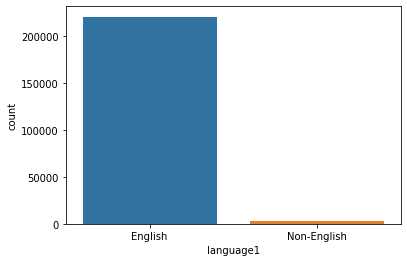

In [18]:
train_df['language1'] = np.where(train_df['language'] != 'English', 'Non-English', train_df['language'])
train_df['language1'].value_counts()
sns.countplot(x='language1', data=train_df)

<AxesSubplot:>

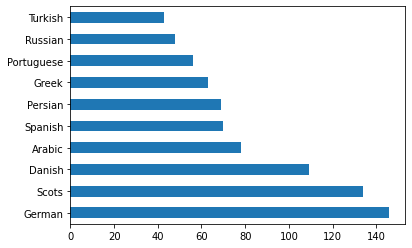

In [19]:
non_eng_df = train_df[(train_df['language1'] == 'Non-English') & (train_df['language'] != 'un')]
non_eng_df['language'].value_counts()[:10].plot(kind='barh')

<AxesSubplot:xlabel='comment_len', ylabel='Density'>

<AxesSubplot:xlabel='comment_len', ylabel='Density'>

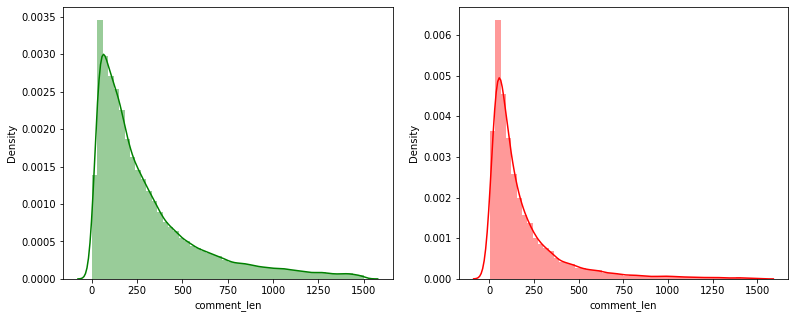

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
train_df['comment_len'] = train_df['comment_text'].apply(len)

non_toxic_df = train_df[(train_df['toxic'] == 0) & (train_df['comment_len'] <= 1500)]
sns.distplot(non_toxic_df['comment_len'], color='green', ax=ax[0])

toxic_df = train_df[(train_df['toxic'] == 1) & (train_df['comment_len'] <= 1500)]
sns.distplot(toxic_df['comment_len'], color='red', ax=ax[1])

<AxesSubplot:xlabel='word_count', ylabel='Density'>

<AxesSubplot:xlabel='word_count', ylabel='Density'>

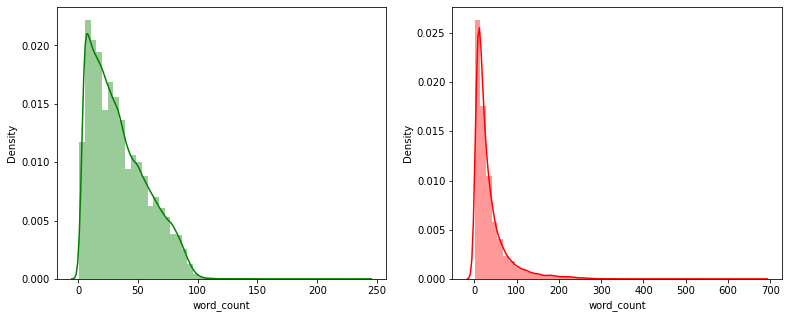

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
train_df['word_count'] = train_df['comment_text'].apply(lambda x: len(x) - len(''.join(x.split())) + 1)

non_toxic_df = train_df[(train_df['toxic'] == 0) & (train_df['comment_len'] <= 500)]
sns.distplot(non_toxic_df['word_count'], color='green', ax=ax[0])

toxic_df = train_df[(train_df['toxic'] == 1) & (train_df['comment_len'] <= 1500)]
sns.distplot(toxic_df['word_count'], color='red', ax=ax[1])

In [22]:
def polarity(x):
    if type(x) == str:
        return SIA.polarity_scores(x)
    else:
        return 1000
    
SIA = SentimentIntensityAnalyzer()
train_df["sentiment"] = train_df["comment_text"].progress_apply(polarity)

  0%|          | 0/223549 [00:00<?, ?it/s]

In [23]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tag_counts,language,language1,comment_len,word_count,sentiment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,English,English,264,43,"{'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'comp..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,English,English,112,18,"{'neg': 0.099, 'neu': 0.743, 'pos': 0.158, 'co..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,English,English,233,42,"{'neg': 0.083, 'neu': 0.849, 'pos': 0.068, 'co..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,English,English,622,116,"{'neg': 0.022, 'neu': 0.916, 'pos': 0.062, 'co..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,English,English,67,13,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp..."


In [24]:
import plotly.graph_objects as go

In [25]:
fig = go.Figure(go.Histogram(x=[pols["neg"] for pols in train_df["sentiment"] if pols["neg"] != 0], marker=dict(
            color='red')
    ))

fig.update_layout(xaxis_title="Negativity sentiment", title_text="Negativity sentiment")

In [26]:
fig = go.Figure(go.Histogram(x=[pols["pos"] for pols in train_df["sentiment"] if pols["pos"] != 0], marker=dict(
            color='green')
    ))

fig.update_layout(xaxis_title="Positivity sentiment", title_text="Positivity sentiment")